In [ ]:
from google.colab import drive
drive.mount('/content/drive')
image_dir = '/content/drive/MyDrive/NSSHME-dataset/Thesisdata'
label_dir = '/content/drive/MyDrive/NSSHME-dataset/label'

Mounted at /content/drive


In [ ]:
# Installation of required packages if not already installed
! if [ ! $pip_done ]; then pip install -q transformers ;fi
! if [ ! $pip_done ]; then pip install -q datasets jiwer ;fi
! if [ ! $pip_done ]; then pip install -q sentencepiece ;fi

# Setting a flag to indicate that pip installations are done
pip_done = 1

# Imports necessary libraries/modules
import os
from os.path import join
from PIL import Image
import warnings

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Image as ipyImage
from IPython.display import display, Latex
import nltk

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing

import torch
from torch.utils.data import Dataset
from transformers import TrOCRProcessor
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel
from datasets import load_metric

# Set pandas display options and disable tokenizers parallelism
pd.set_option('display.max_colwidth', 1000)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

# Function to read labels from text files
def read_labels(label_dir):
    labels = []
    for filename in sorted(os.listdir(label_dir)):
        if filename.endswith('.txt'):
            with open(os.path.join(label_dir, filename), 'r') as file:
                label_text = file.read().strip()  # Read and strip whitespace
                labels.append(label_text)
    return labels

# Function to get image filenames
def get_image_filenames(image_dir):
    image_filenames = []
    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith('.png'):
            image_filenames.append(filename)
    return image_filenames

# Read labels from label directory
labels = read_labels(label_dir)

# Get image filenames from image directory
image_filenames = get_image_filenames(image_dir)

# Create a DataFrame to store image filenames and corresponding labels
data = {'text': labels, 'file_name': image_filenames}
df = pd.DataFrame(data)

# Save the text labels to a CSV file
df['text'].to_csv('/content/drive/My Drive/NSSHME-dataset/formulas.csv', index=False)
formulas_file = '/content/drive/My Drive/NSSHME-dataset/formulas.csv'

df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.8 MB/s eta 0:00:00


,text,file_name
0,x = 9 \times 2,0001.png
1,x = 18,0002.png
2,\frac{3}{4} = \frac{a}{20},0003.png
3,4a = 60,0004.png
4,4 \times a = 3 \times 20,0005.png
...,...,...
542,\frac{\theta}{360} \times 2\pi r + 2r,0546.png
543,\frac{\theta}{360} \times 2\pi r,0547.png
544,x = \sqrt 81,0548.png
545,\frac{1}{2} (a +b)h,0549.png


507    2 \times \frac{22}{7} \times r
Name: text, dtype: object


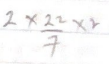

In [ ]:
# Preview a random image and its label
sample = df.sample(n=1)
print(sample['text'])
ipyImage(join(image_dir, sample.iloc[0]['file_name']))

In [ ]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.1)

# Reset the index of both DataFrames
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Size of vocabulary in tokenizer, i.e., distinct number of tokens to learn
vocab_size = 600

# Maximum length of equation in # of tokens
max_length_token = 100

# Setup a tokenizer using the tokenizers library
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.enable_padding(length=max_length_token)
tokenizer.enable_truncation(max_length=max_length_token)

# Setup a WordLevelTrainer for training the tokenizer
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"],
                           vocab_size=vocab_size,
                           show_progress=True)

tokenizer.pre_tokenizer = Whitespace()

tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", 1),
        ("[SEP]", 2),
    ],
)

# Train the tokenizer on the text data and save it
files = [formulas_file]
tokenizer.train(files, trainer)
tokenizer.save("tokenizer-wordlevel.json")




In [ ]:
# Example usage of the tokenizer
i = 5
print(tokenizer.encode(df.loc[i, 'text']).tokens)
print(tokenizer.encode(df.loc[i, 'text']).ids)
print(tokenizer.token_to_id("[PAD]"))

['[CLS]', '\\', 'frac', '{', '4a', '}{', '4', '}', '=', '\\', 'frac', '{', '60', '}{', '4', '}', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 5, 8, 9, 115, 10, 18, 7, 6, 5, 8, 9, 79, 10, 18, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# Maximum length of equation in # of tokens
max_length_token = 100

# Batch size for DataLoader
batch_size = 16

# Custom dataset class to load images and corresponding labels
class NSSHMEDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer, max_target_length=max_length_token):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # Prepare image (resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        labels = self.tokenizer.encode(text).ids
        labels = [label if label != self.tokenizer.token_to_id("[PAD]") else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

root_dir = image_dir + '/'
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")

# Setup training and evaluation datasets
train_dataset = NSSHMEDataset(root_dir=root_dir,
                              df=train_df,
                              processor=processor,
                              tokenizer=tokenizer)
eval_dataset = NSSHMEDataset(root_dir=root_dir,
                             df=test_df,
                             processor=processor,
                             tokenizer=tokenizer)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Number of training examples: 492
Number of validation examples: 55


In [ ]:
# Preview an example label
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
labels = encoding['labels']
labels[labels == -100] = tokenizer.token_to_id("[PAD]")
label_str = tokenizer.decode(labels.tolist(), skip_special_tokens=True)
print(label_str)

# DataLoader for training and evaluation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)

# Version number for model
version = 1

# Report loss every N steps
report_step = 100

# Number of epochs to train
num_epoch = 20

# Device to run the model on (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained vision encoder-decoder model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
model.to(device)

# Set special tokens and parameters for the model
model.config.decoder_start_token_id = tokenizer.token_to_id("[CLS]")
model.config.pad_token_id = tokenizer.token_to_id("[PAD]")
model.config.vocab_size = vocab_size

model.config.eos_token_id = tokenizer.token_to_id("[SEP]")
model.config.max_length = max_length_token
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

model.tokenizer = tokenizer
cer_metric = load_metric("cer")


pixel_values torch.Size([3, 384, 384])
labels torch.Size([100])
\ frac { 4p - 18 }{ 9p } = 0


config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Function to compute Character Error Rate (CER)
def compute_cer(pred_ids, label_ids):
    pred_str = tokenizer.decode_batch(pred_ids.tolist(), skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.token_to_id("[PAD]")
    label_str = tokenizer.decode_batch(label_ids.tolist(), skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

# Set generation parameters to model's config
model.config.max_length = 100
model.config.early_stopping = True
model.config.num_beams = 4
model.config.length_penalty = 2.0
model.config.no_repeat_ngram_size = 3

# Optimizer setup
from tqdm.notebook import tqdm
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

# List to store loss values
loss_vals = []

# Training loop
for epoch in range(num_epoch):
    # Train the model
    model.train()
    train_loss = 0.0
    for i, batch in enumerate(train_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        if i % report_step == 0:
            print(f"Loss: {loss.item()}")

    loss = train_loss / len(train_dataloader)
    loss_vals.append(loss)
    print(f"Loss after epoch {epoch}:", loss)

# Save the trained model
model.save_pretrained(f"version_{version}/final")


Loss: 19.995197296142578
Loss after epoch 0: 3.1574304661443158
Loss: 0.7838180065155029
Loss after epoch 1: 0.6590837038332417
Loss: 0.6634619235992432
Loss after epoch 2: 0.5338277239953318
Loss: 0.6479682326316833
Loss after epoch 3: 0.4747873688897779
Loss: 0.4029724597930908
Loss after epoch 4: 0.4360096521915928
Loss: 0.3312489688396454
Loss after epoch 5: 0.4068373230195815
Loss: 0.35699015855789185
Loss after epoch 6: 0.3828380021356767
Loss: 0.3306499123573303
Loss after epoch 7: 0.36618190715389864
Loss: 0.309212863445282
Loss after epoch 8: 0.3517909001919531
Loss: 0.3443996012210846
Loss after epoch 9: 0.3400559002353299
Loss: 0.3061779737472534
Loss after epoch 10: 0.3278659985911462
Loss: 0.3392798602581024
Loss after epoch 11: 0.3145349544863547
Loss: 0.22555381059646606
Loss after epoch 12: 0.30449994533292707
Loss: 0.322096586227417
Loss after epoch 13: 0.2949332099768423
Loss: 0.23265042901039124
Loss after epoch 14: 0.28764199105001265
Loss: 0.29447197914123535
Loss 

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 100, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be

Loss after epoch 19: 0.249053307598637


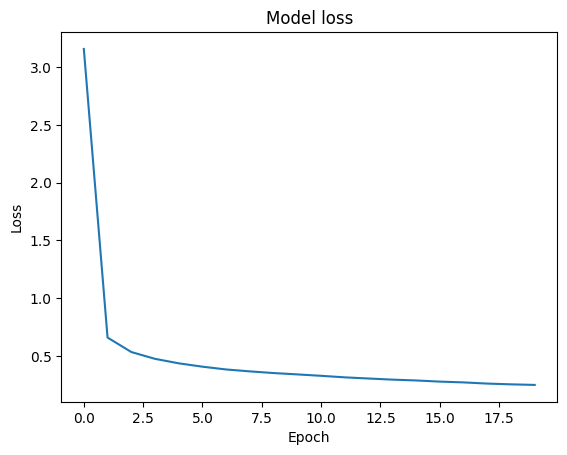

In [ ]:
# Plot the loss values
plt.plot(loss_vals)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


True label: 2am-3m^2+4an-6mn
Pred. label: \frac{1}{4}+1+1-1.1.5.1)+1}=0.1+5.5


<IPython.core.display.Latex object>

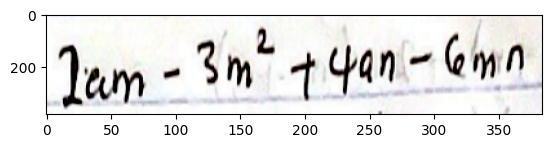

In [ ]:
# DataLoader for testing
test_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

# Example testing
i = 0
for batch in (test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)
    outputs = model.generate(batch["pixel_values"].to(device))
    px = batch["pixel_values"][i].cpu().numpy()
    labels = batch["labels"][i]
    pred = outputs[i]
    break


plt.imshow(px.transpose([1,2,0]), aspect=1/5)
label_true = tokenizer.decode(labels.tolist()).replace(" ", "")
label_pred = tokenizer.decode(pred.tolist()).replace(" ", "")

print('True label: ' + label_true)
print('Pred. label: ' + label_pred)

pred_latex = Latex(f'${label_pred}$')
display(pred_latex)


In [ ]:
# Evaluation
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for i, batch in enumerate(eval_dataloader):
        outputs = model.generate(batch["pixel_values"].to(device))
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer

print("Validation CER:", valid_cer / len(eval_dataloader))


Validation CER: 0.9218661629947004


In [ ]:
# Function to get predicted and true strings
def get_pred_and_label_str(pred, label):
    pred_str = tokenizer.decode_batch(pred.tolist(), skip_special_tokens=True)
    label[label == -100] = tokenizer.token_to_id("[PAD]")
    label_str = tokenizer.decode_batch(label.tolist(), skip_special_tokens=True)
    return (pred_str, label_str)

# BLEU score computation
candidate_corpus = []
references_corpus = []
valid_bleu = 0.0

with torch.no_grad():
    for i, batch in enumerate(eval_dataloader):
        outputs = model.generate(batch["pixel_values"].to(device))
        pred, label = get_pred_and_label_str(outputs, batch["labels"])
        for s in pred: s = s.split(" ")
        for s in label: s = s.split(" ")
        candidate_corpus.extend(pred)
        references_corpus.extend(label)

valid_bleu =  nltk.translate.bleu_score.corpus_bleu(
        references_corpus, candidate_corpus,
        weights=(0.25, 0.25, 0.25, 0.25)
)
valid_bleu

1.1938300526722613e-231